In [3]:
#module import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [4]:
#device check
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch Version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch Version: 1.6.0  Device: cpu


In [5]:
BATCH_SIZE = 32
EPOCHS = 10

In [6]:
train_dataset = datasets.MNIST(root = '../data/MNIST',
                               train = True,
                               download = True,
                               transform = transforms.ToTensor());
test_dataset = datasets.MNIST(root = '../data/MNIST',
                              train = False,
                              transform = transforms.ToTensor());

Processing...
Done!


/Users/rbk/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:299: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-as628lz5/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [8]:
#mini-batch 단위로 할당된 데이터의 개수와 형태를 확인
for(x_train, y_train) in train_loader:
    print('x_train:', x_train.size(), ' type:', x_train.type())
    print('x_train:', y_train.size(), ' type:', y_train.type())
    break

x_train: torch.Size([32, 1, 28, 28])  type: torch.FloatTensor
x_train: torch.Size([32])  type: torch.LongTensor


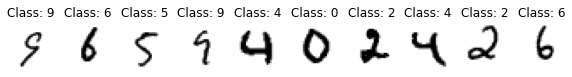

In [9]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28, 28), cmap = 'gray_r')
    plt.title('Class: '+str(y_train[i].item()))

In [10]:
#MLP model 설계
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x): #Forward Propagation 정의
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) #softmax를 이용해 최종 결과 값을 계산. log를 사용하는 이유는 loss gradient 값의 원활한 계산을 위해서
        return x

In [11]:
model = Net().to(DEVICE)
#Back Propagation을 이용해 파라미터를 업데이트 할 때 이용하는 optimizer
#Stochastic Gradient Descent 알고리즘을 이용
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [12]:
#MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능 확인
def train(model, train_loader, optimizer, log_interval):
    model.train() #기존에 정의한 MLP 모델을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() #optimizer의 gradient 초기화
        output = model(image)
        loss = criterion(output, label) #cross entropy 이용해 loss 값 계산
        loss.backward() #계산된 loss 값을 바탕으로 back propagation을 통해 계산된 gradient 값을 각 파라미터에 할당
        optimizer.step() #각 파라미터에 할당된 gradient 값을 이용해 파라미터 값 업데이트
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                    Epoch, batch_idx * len(image),
                    len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                    loss.item()))

In [13]:
#학습 과정 중 검증 데이터에 대한 모델 성능을 확인하는 함수
def evaluate(model, test_loader):
    model.eval() #mlp 모델을 평가 상태로 지정
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): #평가 단계에서는 gradient를 통해 파라미터의 값 갱신 방지
        for image, label in test_loader: 
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1] #계산된 벡터 내 값 중 가장 큰 값에 대해 해당 클래스로 예측했다고 판단
            correct += prediction.eq(label.view_as(prediction)).sum().item() #예측 클래스 값과 실제 레이블의 클래스가 일치하면 예측 횟수 저장
        
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [14]:
#mlp 학습을 실행하면서 train, test set의 loss 및 test set accuracy를 확인
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n'.
         format(Epoch, test_loss, test_accuracy))

/Users/rbk/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.346227
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 2.284641
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 2.291227
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 2.273029
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 2.310088
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 2.273258
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 2.303827
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 2.266889
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 2.296251
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 2.203196

[EPOCH: 1], 	Test Loss: 0.0696, 	Test Accuracy: 16.19 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 2.228896
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 2.223995
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 2.087426
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 2.133682
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 1.890655
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 1.742697
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 1.511252
Train Epoch: 2 [448